In [2]:
import pandas as pd
import wget
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing


In [3]:
# read in confirmed cases

all_data = pd.read_csv("../dataset_all.csv")

all_data = all_data[all_data.columns[1:]]

all_data


,date,state,positive,death,total,Chinawords,Italywords,USwords,Outbreakwords,twitter_number,...,stp,wdsp,prcp,fog,coronavirus,covid,dry cough,fever,shortness of breath,face mask
0,2020-04-11,AK,257.0,8.0,7732,918,97,1240,188,1047513,...,27.6,7.1,0.00,0,32,62,0,21,0,33
1,2020-04-11,AL,3191.0,91.0,21249,918,97,1240,188,1047513,...,999.9,5.7,0.00,0,33,58,0,35,40,37
2,2020-04-11,AR,1226.0,24.0,18578,918,97,1240,188,1047513,...,3.8,4.4,0.00,0,33,56,0,27,66,30
3,2020-04-11,AZ,3393.0,108.0,40530,918,97,1240,188,1047513,...,965.1,3.8,0.00,0,41,67,19,43,0,41
4,2020-04-11,CA,19472.0,609.0,185276,918,97,1240,188,1047513,...,9.0,3.7,0.00,0,39,75,15,51,45,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1438,2020-01-26,WA,1.0,0.0,1,3802,1,708,1142,1356180,...,875.6,2.7,0.55,1,12,0,13,35,58,6
1439,2020-01-25,WA,1.0,0.0,1,3558,2,448,1320,998717,...,876.5,1.5,0.14,1,10,0,14,53,21,3
1440,2020-01-24,WA,1.0,0.0,1,3207,0,487,1054,660769,...,874.9,2.2,1.13,1,8,0,0,36,19,2
1441,2020-01-23,WA,1.0,0.0,1,1436,3,107,524,186460,...,878.0,2.7,0.52,1,6,0,12,33,36,1


In [3]:
def get_previous_date(date, interval):
    return str(datetime.strptime(date, "%Y-%m-%d").date() - timedelta(days=interval))

def find_row(date, state, df, col):
    df2 = df[df["date"] == date]
    res = df2[df2["state"] == state]
        
    if len(res) == 0:
        return None
    
    return res[col].values[0]

all_data['t-1'] = 0
all_data['t-2'] = 0
all_data['t-3'] = 0

all_data['keep_data'] = False

#build data set
for i, row in all_data.iterrows():
    date = row['date']
    state = row['state']
    
    keep_data = True
    
    val = find_row(get_previous_date(date, 3), state, all_data, "positive")
    all_data.at[i,'t-3'] = val
    if val == None:
        continue
        
    val = find_row(get_previous_date(date, 2), state, all_data, "positive")
    all_data.at[i,'t-2'] = val
    if val == None:
        continue
        
    val = find_row(get_previous_date(date, 1), state, all_data, "positive")
    all_data.at[i,'t-1'] = val
    if val == None:
        continue
        
    cols = ["death", "twitter_number", "temp", "stp", "wdsp", "prcp", "fog",
            "coronavirus", "covid", "dry cough", "fever", "shortness of breath", "face mask"]
    for col in cols:
        val = find_row(get_previous_date(date, 1), state, all_data, col)
        all_data.at[i, col] = val
        if val == None:
            keep_data = False
            break
    
    all_data.at[i,'keep_data'] = keep_data


all_data = all_data[all_data["keep_data"] == True]
all_data


,date,state,positive,death,total,Chinawords,Italywords,USwords,Outbreakwords,twitter_number,...,coronavirus,covid,dry cough,fever,shortness of breath,face mask,t-1,t-2,t-3,keep_data
0,2020-04-11,AK,257.0,7.0,7732,918,97,1240,188,995210,...,41,64,50,19,45,37,246.0,235.0,226.0,True
1,2020-04-11,AL,3191.0,80.0,21249,918,97,1240,188,995210,...,42,62,29,36,17,30,2968.0,2769.0,2369.0,True
2,2020-04-11,AR,1226.0,23.0,18578,918,97,1240,188,995210,...,43,72,29,27,0,29,1171.0,1119.0,1000.0,True
3,2020-04-11,AZ,3393.0,97.0,40530,918,97,1240,188,995210,...,50,70,24,26,39,39,3112.0,3018.0,2726.0,True
4,2020-04-11,CA,19472.0,541.0,185276,918,97,1240,188,995210,...,51,79,14,49,35,46,19472.0,18309.0,16957.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,2020-01-29,WA,1.0,0.0,1,7254,10,1082,1383,875551,...,15,0,12,16,18,6,1.0,1.0,1.0,True
1436,2020-01-28,WA,1.0,0.0,1,4063,5,644,1202,989434,...,14,0,12,32,0,2,1.0,1.0,1.0,True
1437,2020-01-27,WA,1.0,0.0,1,3383,9,644,1095,1356180,...,12,0,13,35,58,6,1.0,1.0,1.0,True
1438,2020-01-26,WA,1.0,0.0,1,3802,1,708,1142,998717,...,10,0,14,53,21,3,1.0,1.0,1.0,True


In [4]:
# split train test

train_data = all_data.query('date < "2020-04-01"')

test_data = all_data.query('date >= "2020-04-01"')

# train_data = all_data
# test_data = all_data

X_train = train_data[["t-3", "t-2", "t-1", "death", "twitter_number", "temp", "stp", "wdsp", "prcp", "fog",
            "coronavirus", "covid", "dry cough", "fever", "shortness of breath", "face mask"]]
# no intercept
y_train = train_data[['positive']]

X_test = test_data[["t-3", "t-2", "t-1", "death", "twitter_number", "temp", "stp", "wdsp", "prcp", "fog",
            "coronavirus", "covid", "dry cough", "fever", "shortness of breath", "face mask"]]

y_test = test_data["positive"]



In [5]:

OLSModel = OLS(y_train, X_train).fit()
print(OLSModel.summary())

                                 OLS Regression Results                                
Dep. Variable:               positive   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              5586.
Date:                Sat, 09 May 2020   Prob (F-statistic):                        0.00
Time:                        10:48:27   Log-Likelihood:                         -3952.8
No. Observations:                 726   AIC:                                      7938.
Df Residuals:                     710   BIC:                                      8011.
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [6]:
r2_trainingset = OLSModel.rsquared

yhat = OLSModel.predict(X_test)
r2_testset = r2_score(y_test, yhat)
print("R2 on training sets: "+ str(r2_trainingset))
print("R2 on test sets: "+ str(r2_testset))
print("MSE on test sets: "+ str(mean_squared_error(y_test, yhat)))


R2 on training sets: 0.9921189580792759
R2 on test sets: 0.9987252145423021
MSE on test sets: 576956.0887623877


In [7]:
OLSModel = OLS(y_train, X_train).fit_regularized(method = 'sqrt_lasso')

yhat = OLSModel.predict(X_test)
print("MSE on test sets: "+ str(mean_squared_error(y_test, yhat)))


MSE on test sets: 576905.614675022


/Users/yaoyanglin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/yaoyanglin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


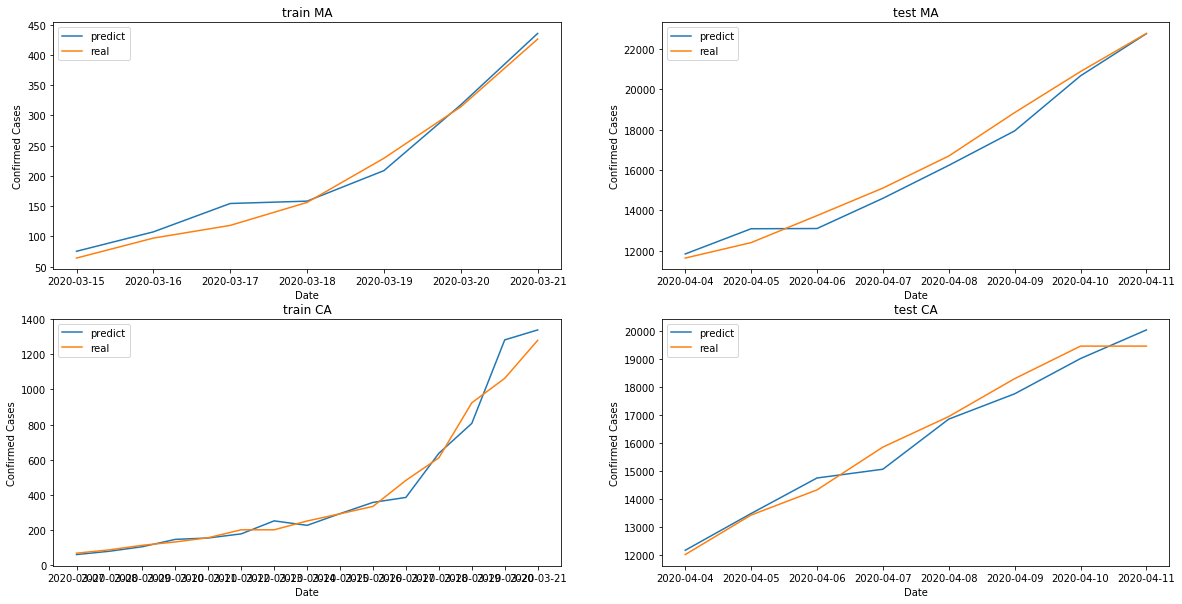

In [8]:
def plot_state_trend(train_data, test_data, model, X_train, X_test, states):
    f, ax = plt.subplots(len(states), 2, figsize=(20,10))
    
    train_data["predict"] = model.predict(X_train)
    test_data["predict"] = model.predict(X_test)
    
    for i in range(len(states)):
        
        df = train_data[train_data["state"]==states[i]]
        df = df.sort_values(by=["date"])

        ax[i, 0].plot(df["date"], df["predict"], label="predict")
        ax[i, 0].plot(df["date"], df["positive"], label="real")
        ax[i, 0].set_xlabel('Date')
        ax[i, 0].set_ylabel('Confirmed Cases')
        ax[i, 0].legend()
        ax[i, 0].set_title('train '+ states[i])


        df = test_data[test_data["state"]==states[i]]
        df = df.sort_values(by=["date"])

        ax[i, 1].plot(df["date"], df["predict"], label="predict")
        ax[i, 1].plot(df["date"], df["positive"], label="real")
        ax[i, 1].set_xlabel('Date')
        ax[i, 1].set_ylabel('Confirmed Cases')
        ax[i, 1].legend()
        ax[i, 1].set_title('test '+ states[i])
    
    
plot_state_trend(train_data, test_data, OLSModel, X_train, X_test, ["MA", "CA"])

In [9]:
OLSModel = OLS(train_data[['positive']], train_data[["t-3", "t-2", "t-1"]]).fit_regularized(method = 'sqrt_lasso')

yhat = OLSModel.predict(test_data[["t-3", "t-2", "t-1"]])
print("MSE on test sets: "+ str(mean_squared_error(y_test, yhat)))


MSE on test sets: 378285.96761262


In [10]:
X_train_normalized = (X_train-X_train.mean())/X_train.std()
X_test_normalized = (X_test-X_train.mean())/X_train.std()

OLSModel = OLS(y_train, X_train_normalized).fit_regularized(method = 'sqrt_lasso')

yhat = OLSModel.predict(X_test_normalized)
print("MSE on test sets: "+ str(mean_squared_error(y_test, yhat)))


MSE on test sets: 644216.4732882999


/Users/yaoyanglin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/yaoyanglin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


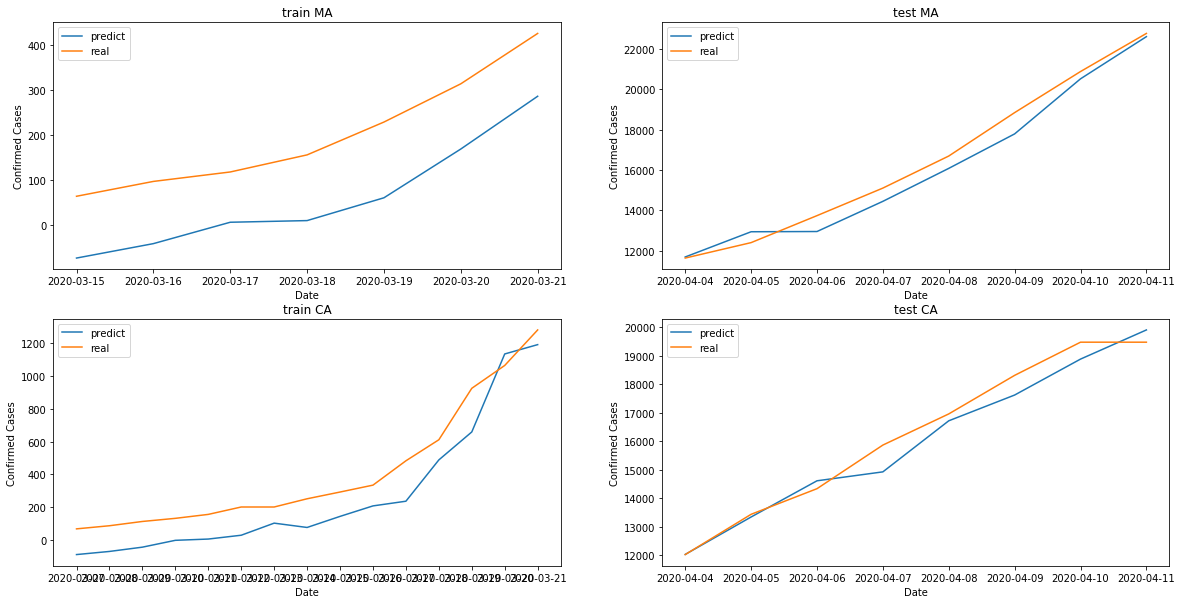

In [11]:
plot_state_trend(train_data, test_data, OLSModel, X_train_normalized, X_test_normalized, ["MA", "CA"])
